In [3]:
import  sys

#LOCALISATION DES DONNEES
sys.path.insert(0, "C:/projets_python/diabolo")

import warnings
warnings.filterwarnings("ignore")



#LIBRAIRIES PERSO
import etude_variable.MyLog as log
import etude_variable.jouer as jouer
import etude_variable.lecture_data as ld
import etude_variable.analyse as ana

# LIBRAIRIE PYHTON CLASSIQUES
import pandas as pd
import numpy as np
import matplotlib
import scipy
import platform

from collections import Counter

#ESTIMATEUR
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn import neighbors, datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer

from scipy.stats import uniform
from scipy.stats import randint

#TRAINING
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import dask_searchcv as dcv
from skopt.space import Real, Integer

#Evaluateur
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectFromModel


from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.utils import class_weight

#outils
from dask.diagnostics import ProgressBar
import logging


#Metriques
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn import  metrics
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import  classification_report

#Outils

import time


#Graphique
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns

print('Operating system version....', platform.platform())
print("Python version is........... %s.%s.%s" % sys.version_info[:3])
print('scikit-learn version is.....', sklearn.__version__)
print('pandas version is...........', pd.__version__)
print('numpy version is............', np.__version__)
print('matplotlib version is.......', matplotlib.__version__)
print('scipy version is.......', scipy.__version__)


Operating system version.... Windows-10-10.0.17134-SP0
Python version is........... 3.6.5
scikit-learn version is..... 0.19.1
pandas version is........... 0.22.0
numpy version is............ 1.14.2
matplotlib version is....... 2.2.0
scipy version is....... 1.0.0


In [6]:
def split_dataset(dataset, train_percentage, feature_headers,
                                  target_header,random_state=42,mode_debug=0):

    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage, test_size=None, random_state=42)


    if mode_debug==1:
        # Train and Test dataset size details
        print("--------------------------------")
        print("Train_x Shape :: ", train_x.shape)
        print("Train_y Shape :: ", train_y.shape)
        print("Test_x Shape :: ", test_x.shape)
        print("Test_y Shape :: ", test_y.shape)
        print("--------------------------------")

    return train_x, test_x, train_y, test_y


def construireFichierCSV(allure, best_model, feature_columns, response_column, mode_debug=0):
    # lecture des données a jouer


    xnames = ['ALLURE', 'CO_DISTANCE',
              'CO_PRIX', 'HIPPO',
              'IDCOURSE', 'IDPARTCIPANT',
              'PAR_AGE', 'PAR_ARRIVE',
              'PAR_CARRIERE',
              'PAR_CARRIERE_Q',
              'PAR_CLASSE_AGE',
              'PAR_COTEDER',
              'PAR_ENT_ECART_GAGNANT',
              'PAR_ENT_RAPPORT_GAGNANT_M',
              'PAR_ENT_REU_PLACE',
              'PAR_ENT_REUSSITE_GAGNE',
              'PAR_ENT_VICTOIRE',
              'PAR_GAIN',
              'pAR_JOC_ECART_GAGNANT',
              'PAR_JOC_ECART_PLACE',
              'PAR_JOC_NB_COURSE',
              'PAR_JOC_PLACE_3P',
              'pAR_JOC_RAPPORT_GAGNANT_M',
              'PAR_JOC_REU_PLACE',
              'pAR_JOC_REUSSITE_GAGNE',
              'pAR_JOC_VICTOIRE',
              'PAR_NP',
              'PAR_NUM',
              'PAR_PLACE',
              'PAR_PLACE_Q',
              'PAR_REUSSITE_3P',
              'PAR_REUSSITE_GAGNE',
              'PAR_REUSSITE_QUINTE',
              'PAR_RUESSITE_PLACE',
              'autostart',
              'cendre',
              'grande_piste',
              'Point',
              'Nb_partant', 'PAR_PROPRIO',
              'NOM_JOC',
              'NOM_ENTR',
              'POIDS',
              'CORDE',
              'CHEVAL','MUSIC_CHEVAL', 'MUSIC_ENT',
              'MUSIC_JOC',
              'PAR_VALEUR',
              'FIN_ligne']



    df_numero_a_predire = ld.lecture_data('d:\data_jour.csv', xnames, ['IDPARTCIPANT', 'IDCOURSE'],allure=allure,avec_index=True)
    df_numero_a_predire = df_numero_a_predire.groupby("ALLURE")
    df_numero_a_predire = df_numero_a_predire.get_group(allure)
    df_numero_a_predire = ld.my_drop(df_numero_a_predire, 'ALLURE')
    df_numero_a_predire = ld.my_drop(df_numero_a_predire, 'PAR_ARRIVE')
    df_numero_a_predire['SELECTION'] = 0


    train_x, test_x, train_y, test_y = split_dataset(df_numero_a_predire, 0, feature_columns, response_column)
    test_y = test_y['SELECTION'].ravel()

    # sauvegarde
    y_pred = best_model.predict(test_x)
    df_pred = pd.DataFrame.from_dict(y_pred)
    test_copy = test_x.copy()
    
    # UTILISATION DE BEST_MODEL
    PROBA = best_model.predict_proba(test_x)
    #print("PROBA \n %s" ,PROBA)

    df_proba = pd.DataFrame.from_dict(PROBA)
    #print(   df_proba)

    #print("df final=")
    df_final = pd.concat([df_proba, df_pred], axis=1)
    print(df_final.head(5))

    test_x = test_copy.copy()
    test_x = ld.my_drop(test_x, 'PAR_CLASSE_AGE')
    test_x = ld.my_drop(test_x, 'PAR_ENT_ECART_GAGNANT')
    test_x = ld.my_drop(test_x, 'PAR_ENT_RAPPORT_GAGNANT_M')
    test_x = ld.my_drop(test_x, 'PAR_ENT_REU_PLACE')
    test_x = ld.my_drop(test_x, 'PAR_ENT_REUSSITE_GAGNE')
    test_x = ld.my_drop(test_x, 'PAR_ENT_VICTOIRE')
    test_x = ld.my_drop(test_x, 'PAR_GAIN')
    test_x = ld.my_drop(test_x, 'pAR_JOC_ECART_GAGNANT')
    test_x = ld.my_drop(test_x, 'PAR_JOC_ECART_PLACE')
    test_x = ld.my_drop(test_x, 'PAR_JOC_NB_COURSE')
    test_x = ld.my_drop(test_x, 'PAR_JOC_PLACE_3P')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_GAGNE')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_QUINTE')
    test_x = ld.my_drop(test_x, 'PAR_RUESSITE_PLACE')
    test_x = ld.my_drop(test_x, 'CO_PRIX')
    test_x = ld.my_drop(test_x, 'PAR_CARRIERE')
    test_x = ld.my_drop(test_x, 'PAR_CARRIERE_Q')
    test_x = ld.my_drop(test_x, 'pAR_JOC_RAPPORT_GAGNANT_M')
    test_x = ld.my_drop(test_x, 'pAR_JOC_REUSSITE_GAGNE')
    test_x = ld.my_drop(test_x, 'pAR_JOC_VICTOIRE')
    test_x = ld.my_drop(test_x, 'PAR_PLACE')
    test_x = ld.my_drop(test_x, 'PAR_PLACE_Q')
    test_x = ld.my_drop(test_x, 'PAR_CLASSE_AGE')
    test_x = ld.my_drop(test_x, 'pAR_JOC_VICTOIRE')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_3P')
    test_x = ld.my_drop(test_x, 'PAR_JOC_REU_PLACE')
    test_x = ld.my_drop(test_x, 'PAR_NUM')
    test_x = ld.my_drop(test_x, 'PAR_COTEDER')
    test_x = ld.my_drop(test_x, 'CORDE')
    test_x = ld.my_drop(test_x, 'musique')
    test_x = ld.my_drop(test_x, 'CHEVAL')
    test_x = ld.my_drop(test_x, 'Nb_partant')

    test_x = ld.my_drop(test_x, 'autostart')
    test_x = ld.my_drop(test_x, 'grande_piste')
    test_x = ld.my_drop(test_x, 'cendre')

    test_x = ld.my_drop(test_x, 'PAR_PROPRIO')
    test_x = ld.my_drop(test_x, 'NOM_JOC')
    test_x = ld.my_drop(test_x, 'NOM_ENTR')

    test_x = ld.my_drop(test_x, 'HIPPO')
    test_x = ld.my_drop(test_x, 'PAR_AGE')
    test_x = ld.my_drop(test_x, 'POIDS')
    test_x = ld.my_drop(test_x, 'CO_DISTANCE')
    test_x = ld.my_drop(test_x, 'CO_PRIX')
    test_x = ld.my_drop(test_x, 'PAR_GAIN_NORMA')
    test_x = ld.my_drop(test_x, 'CHEVAL2')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_3P2')
    test_x = ld.my_drop(test_x, 'PAR_REUSSITE_QUINTE2')
    test_x = ld.my_drop(test_x, 'PAR_CLASSE_AGE2')
    test_x = ld.my_drop(test_x, 'PAR_COTEDER2')

    test_x = ld.my_drop(test_x, 'MUSIC_CHEVAL')
    test_x = ld.my_drop(test_x, 'MUSIC_ENT')
    test_x = ld.my_drop(test_x, 'MUSIC_JOC')
    test_x = ld.my_drop(test_x, 'PAR_VALEUR')

    test_x['v0'] = 0.0
    test_x['v1'] = 0.0
    test_x['sel'] = 0

    print("\n\nTest_x", test_x.head(4))

    # test_x
    cumul = 1
    nb_rows = len(df_proba.index)
    #rint("nb_rows=", nb_rows)

    for i in range(0, nb_rows):
        n = df_proba[0][i]
        test_x['v0'][i] = n

        n = df_proba[1][i]
        test_x['v1'][i] = n


    if (allure == 1):
        test_x.to_csv("d:\py_resultat_trot.csv")

    if (allure == 2):
        test_x.to_csv("d:\py_resultat_galop.csv")

    if (allure == 3):
        test_x.to_csv("d:\py_resultat_trot_monte.csv")

    if (allure == 4):
        test_x.to_csv("d:\py_resultat_haie.csv")

    if (allure == 5):
        test_x.to_csv("d:\py_resultat_steeple.csv")


    print("\n\n ALLER DANS APPLICATION DIABOLO ...Allure %s" % allure)


In [9]:
def explo_variable(dataset, svariable):

     # On calcule le quantile 0,25 qui est le quartile Q1
    mediane = np.median(dataset)
    print ("La mediane              "+svariable+"    : ", round(mediane, 2))

    maxx = np.max(dataset)
    print ("Le max              "+svariable+"    : ", round(maxx, 2))
    
    minn = np.min(dataset)
    print ("Le min              "+svariable+"    : ", round(minn, 2))
    
    
    moy = np.mean(dataset)
    print ("La moyenne               "+svariable+"   : ", round(moy, 2))

    variance = np.var(dataset)
    print ("La variance est          "+svariable+"   : ", round(variance, 2))
    
    ecartType = np.std(dataset)
    print ("Le ecart type            "+svariable+"   : ", round(ecartType, 2))
     
    print("")      
    
   # print(dataset.describe())
    
    print("")    
    

    
def CorrectionDesequilibre(train_x,train_y,feature_columns):

    from imblearn.combine import SMOTEENN
    from imblearn.over_sampling import SMOTE
    #from imblearn.under_sampling import TomekLinks
    #f"rom imblearn.under_sampling import RandomUnderSampler
    #from imblearn.under_sampling import AllKNN


    print('\nOriginal dataset shape {}'.format(Counter(train_y)))
    #sm = SMOTEENN(ratio='minority',n_jobs=4, random_state=42,smote=SMOTE(),n_neighbors=5)
    sm = SMOTE(ratio='auto', n_jobs=3, random_state=42,k_neighbors=50)
    X_res, y_res = sm.fit_sample(train_x, train_y)
    print('\nResampled dataset shape {}'.format(Counter(y_res)))
    # reconstitution DATAFRAME
    train_x = pd.DataFrame(X_res, columns=feature_columns)
    train_y = pd.Series(y_res)
    return train_x,train_y

In [10]:
def my_fit(estimateur, test_x,test_y, train_x, train_y, verbose=False):
    nb_split=80

    

    # Correction du desequiilibre
    #train_x, train_y = smot2(train_x=train_x, train_y=train_y, feature_columns=featurecolums)
    #test_x, test_y = smot2(train_x=test_x, train_y=test_y, feature_columns=featurecolums)


    log.traceLogInfo("\nTEST DU FIT ......DIRECT")
    #kfold = StratifiedKFold(n_splits=nb_split, shuffle=False, random_state=None)
    
    model=estimateur
    
    eval_set = [(train_x, train_y), (test_x, test_y)]
    model.fit(train_x, train_y, eval_metric=["error", "auc"], eval_set=eval_set, verbose=verbose, early_stopping_rounds=10)
    y_pred = model.predict(test_x)
    predictions = [round(value) for value in y_pred]

    
    return model,y_pred,predictions



def my_fit2(estimateur, train_x, train_y):
    kfold = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    
    results = cross_val_score(estimateur, train_x, train_y, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    
    y_pred = model.predict(test_x)
    predictions = [round(value) for value in y_pred]
    return model,y_pred,predictions


    
    


def fit_special(estimateur,    test_x,test_y, train_x, train_y):



    # Use SelectFromModel
    thresholds = np.sort(estimateur.best_estimator_.named_steps["clf"].feature_importances_)

    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(estimateur, threshold=thresh, prefit=True)
        select_X_train = selection.transform(train_x)

        # train model
        selection_model = estimateur
        selection_model.fit(select_X_train, train_y)

        # eval model
        select_X_test = selection.transform(test_x)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(test_y, predictions)
        print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))
        print(confusion_matrix(test_y, predictions))
        print(classification_report(test_y, predictions))

    y_pred = estimateur.predict(test_x)
    predictions = [round(value) for value in y_pred]
    return estimateur,y_pred,predictions


In [11]:
def afficheEvalSet(mybest_model,
                    set_train,
                   set_train_cible,
                   set_test,
                   set_test_cible,
                   mode_debug=0,
                   type_eval=1):

    print("\nEVAL SET ....")

    set_test_cible_predicted = mybest_model.predict(set_test)
    set_train_cible_predicted = mybest_model.predict(set_train)

    if type_eval==1:
                print("Evaluation TEST-----------------------------------------------------------------------")
                set_test_cible_probabilities = mybest_model.predict_proba(set_test)
                score = set_test_cible_probabilities[:, 1]
                auc = roc_auc_score(set_test_cible, set_test_cible_predicted)
                print("TEST roc_auc_score :  %s" % auc)
    else:
                set_train_cible_probabilities = mybest_model.predict_proba(set_train)
                auc = roc_auc_score(set_train_cible, set_train_cible_predicted)
                print("TRAINING roc_auc_score :  %s" % auc)
    
    for x, y in [(set_train, set_train_cible), (set_test, set_test_cible)]:
            yp = mybest_model.predict(x)
            cm = confusion_matrix(y, yp.ravel())
            print(cm)

    import matplotlib.pyplot as plt

    
    
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if type_eval==1:
        ntotal = len(set_test)
        correct = set_test_cible == set_test_cible_predicted
        numCorrect = sum(correct)
        percent = round((100.0 * numCorrect) / ntotal, 3)

        log.traceLogInfo("Classification Correcte des données de test : {0:d}/{1:d}  {2:8.3f}%".format(numCorrect, ntotal, percent))

        prediction_score = 100.0 * mybest_model.score(set_test, set_test_cible)
        log.traceLogInfo('\nScore  TEST  : %8.3f  ************************' % prediction_score)
    else:
        ntotal = len(set_train)
        correct = set_train_cible== set_train_cible_predicted
        numCorrect = sum(correct)
        percent = round((100.0 * numCorrect) / ntotal, 3)

        log.traceLogInfo("\n CLASSIFICATION CORRECTE DES DONNEES DE Train  : {0:d}/{1:d}  {2:8.3f}%".format(numCorrect, ntotal, percent))

        prediction_score = 100.0 * mybest_model.score(set_train, set_train_cible)
        log.traceLogInfo('Score  TRAINING  : %8.3f  ************************' % prediction_score)



# RECHERCHE

In [12]:
  # ICI ON FAIT UNE RECHERCHE DES BON PARAMTRE
def recherche_fit_BayesSearchCV(): 
    model =XGBClassifier(base_score=0.5,
                  booster='gbtree',
                colsample_bylevel=0.6,
                colsample_bytree=0.8,
                 gamma=0.01,
                 learning_rate=0.07, #ok
                max_delta_step=3, #ok
                max_depth=6, #ok
                max_features='sqrt',
                min_child_weight=8, #ok
                n_estimators=1900,#ok
                n_jobs=2,#ok
                nthread=None,
                objective='binary:logistic',
                 random_state=10,
                reg_alpha=0.1, #ok
                reg_lambda=2.5,
                scale_pos_weight=1,
                 seed=800,
                subsample=0.99,
                silent=False
                )
    
    kfold = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    
    print("definition de BayesSearchCV\n ")
    searchcv = BayesSearchCV( model,refit=True, n_jobs=2, scoring="roc_auc",cv=kfold,
                    search_spaces=[

                    
                        ({'n_estimators': Integer(1000, 5000)}, 10),
                        
                 #      ({'max_delta_step': Integer(0, 12)},10),
                    #    (      {'seed': Integer(25, 999)},1)
                        #({'random_state': Integer(5, 50)},5),
                           ( {'colsample_bylevel': Real(2e-1, 1, 'log-uniform')},5),
                           ({'gamma': Real(0.09e-1, 1.20e-1, 'log-uniform')},5),
                           ({'colsample_bytree': Real(1e-1, 7e-1, 'log-uniform')}, 5),
                          #     ( {'learning_rate': Real(0.1e-2,1, 'log-uniform')},10),

                        ], n_iter=200, return_train_score=False,verbose=5
                    )

    
    
    def on_step(optim_result):
        score = searchcv.best_score_
        log.traceLogInfo("best score: %s" % score)
        log.traceLogInfo("Params : %s" % searchcv.best_params_)
        log.traceLogInfo("iteration : %s" % searchcv.total_iterations)
                        #log.traceLogInfo("Params : %s" % searchcv.get_params())
        if score >= 0.99:
                            print('Interrupting!')
                            return True
                        

    print("\nFit AVEC SEARCH ....")
    searchcv.fit(X=train_x, y=train_y, callback=on_step)
    res=pd.DataFrame(searchcv.cv_results_)
    
    print("Test score :",searchcv.score(test_x, test_y))
    print("")
    
    print("\nDonnées bloquées :",searchcv.scorer_)
    print("Nombre de divisions de validation croisée :", searchcv.n_splits_)
    
    res = res.sort_values(by=['mean_test_score'], ascending=False, axis=0)
    res.reset_index(inplace=True, drop=True)
    a = res[['mean_test_score', 'std_test_score']]

    res.drop(['mean_test_score', 'std_test_score', 'params', 'mean_fit_time', 'mean_score_time', 'std_fit_time', 'std_score_time'], axis=1, inplace=True)
    res = pd.concat([a, res], axis=1)

    print("best_score_: {:.4f}\nbest_params_: {}".format(searchcv.best_score_, searchcv.best_params_))
    print("\nTest train :", searchcv.score(train_x,train_y))
    print("\n TOTAL ITERATION : %s" % searchcv.total_iterations)

    print(res.head(5))
                    # SAUVEGARDE DU MODELE
     #                   ld.save_mymodel(clf=searchcv, allure=allure)

                    #  ld.save_mymodel(clf=gsearch, allure=allure)
    
    y_pred = searchcv.predict(test_x)
    predictions = [round(value) for value in y_pred]
    return searchcv,y_pred,predictions


In [13]:
def recherche_random_XGBClassifier( model, x_train, y_train,x_test,y_test,param_grid, nb_iter):
    clf = model

    
    fit_params = {'eval_metric': 'auc',
              'early_stopping_rounds': 10,
              'eval_set': [(x_test, y_test)]}
    
    rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=nb_iter,
                            n_jobs=2, verbose=3, cv=10,
                            fit_params=fit_params,
                            scoring='neg_log_loss', refit=True, random_state=42)
    print("Randomized search..")
    search_time_start = time.time()
    rs_clf.fit(x_train, y_train)
    print("Randomized search time:", time.time() - search_time_start)
    best_score = rs_clf.best_score_
    best_params = rs_clf.best_params_
    
    print("Best score: {}".format(best_score))
    print("Best params: ")
    
    for param_name in sorted(best_params.keys()):
       print('%s: %r' % (param_name, best_params[param_name]))



    y_pred = rs_clf.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    return rs_clf.best_estimator_,y_pred,predictions
    
    
    

In [14]:
def plot_importance(feature_columns, model):
    importances = pd.DataFrame({'feature': feature_columns, 'importance': np.round(model.feature_importances_, 3)})
    importances = importances.sort_values('importance', ascending=False).set_index('feature')
    print("")
    print( importances)
    importances.plot.bar()

def plot_2(model,cr1="auc",cr2="error"):
    
        # retrieve performance metrics
        results = model.evals_result()
        epochs = len(results['validation_0'][cr1])
        x_axis = range(0, epochs)

        # plot log loss
        fig, ax = pyplot.subplots()
        ax.plot(x_axis, results['validation_0'][cr2], label='Train')
        ax.plot(x_axis, results['validation_1'][cr2], label='Test')
        ax.legend()
        pyplot.ylabel('auc')
        pyplot.title('XGBoost Error')
        pyplot.show()

        # plot classification error
        fig, ax = pyplot.subplots()
        ax.plot(x_axis, results['validation_0'][cr1], label='Train')
        ax.plot(x_axis, results['validation_1'][cr1], label='Test')
        ax.legend()
        pyplot.ylabel('Classification Auc')
        pyplot.title('XGBoost Classification Auc')
        pyplot.show()
    
    
    
def evaluation_1(test_y, predictions,featurecolums, model):
    print(classification_report(test_y, predictions))
    plot_importance(feature_columns=featurecolums,model=model)
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    names = feature_columns
    print("----------KBEST-----------------")
    
    for n in range(0, len(names)):
        test = SelectKBest(score_func=chi2, k=9)
        fit = test.fit(train_x, train_y)
        print(names[n],'   ', fit.scores_[n])
    

    print("--------------------------")
    
def evaluation_2(model, train_x, train_y, test_x, test_y):    
    from sklearn.feature_selection import RFE
    rfc=model
    # create the RFE model and select 4 attributes
    rfe_model = RFE(rfc, 9, step=1)
    rfe_model = rfe_model.fit(train_x, train_y)
    # summarize the selection of the attributes
    print(rfe_model.support_)
    print(rfe_model.ranking_)

    # evaluate the model on testing set
    pred_y = rfe_model.predict(test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = accuracy_score(test_y, predictions)
    print("Test Accuracy: %.2f%%" % (accuracy*100.0))
    print(train_x.mean()   )
    
    
def metrique_classe(y_pred,y_true,xclass):
    from imblearn.metrics import specificity_score
    from imblearn.metrics import geometric_mean_score

    #log.traceLogInfo("Classe ", xclass)
    log.traceLogInfo("Sensibilité  du reequilibrage des données sur le TEST")
    log.traceLogInfo("La spécificité est intuitivement la capacité du classificateur à trouver tous les échantillons positifs")
    log.traceLogInfo(specificity_score(y_true, y_pred, labels=None, pos_label=xclass, average='binary', sample_weight=None))
    print("\nCalculer la moyenne géométrique")
    print(geometric_mean_score(y_true, y_pred,labels=None, pos_label=xclass))


# CHAMPS et INDEX

In [15]:
xnames = ['ALLURE', 'CO_DISTANCE',
              'CO_PRIX', 'HIPPO',
              'IDCOURSE', 'IDPARTCIPANT',
              'PAR_AGE', 'PAR_ARRIVE',
              'PAR_CARRIERE',
              'PAR_CARRIERE_Q',
              'PAR_CLASSE_AGE',
              'PAR_COTEDER',
              'PAR_ENT_ECART_GAGNANT',
              'PAR_ENT_RAPPORT_GAGNANT_M',
              'PAR_ENT_REU_PLACE',
              'PAR_ENT_REUSSITE_GAGNE',
              'PAR_ENT_VICTOIRE',
              'PAR_GAIN',
              'pAR_JOC_ECART_GAGNANT',
              'PAR_JOC_ECART_PLACE',
              'PAR_JOC_NB_COURSE',
              'PAR_JOC_PLACE_3P',
              'pAR_JOC_RAPPORT_GAGNANT_M',
              'PAR_JOC_REU_PLACE',
              'pAR_JOC_REUSSITE_GAGNE',
              'pAR_JOC_VICTOIRE',
              'PAR_NP',
              'PAR_NUM',
              'PAR_PLACE',
              'PAR_PLACE_Q',
              'PAR_REUSSITE_3P',
              'PAR_REUSSITE_GAGNE',
              'PAR_REUSSITE_QUINTE',
              'PAR_RUESSITE_PLACE',
              'autostart',
              'cendre',
              'grande_piste',
              'Point',
              'Nb_partant', 'PAR_PROPRIO',
              'NOM_JOC',
              'NOM_ENTR',
              'POIDS',
              'CORDE', 'CHEVAL', 'MUSIC_CHEVAL',
              'MUSIC_ENT',
              'MUSIC_JOC',
              'PAR_VALEUR',
              'FIN_ligne']

index_col = ['IDPARTCIPANT', 'IDCOURSE']


def assign_selection(W):
    if W < 5:
        return 1
    else:
        return 0
    
    # Creating bins for the win column
def assign_selection2(W):
    if W == 1.0:
        return 1
    if W == 0.0:
        return 0



# LECTURE DES DONNEES

In [16]:
allure_etudier=1

In [22]:
  # Lecture des données sans index
df = ld.lecture_data('d:\data_diabolo.csv', xnames, xindex_col=index_col, allure=allure_etudier, avec_index=False)
print(df.info())
    



Lecture data d:\data_diabolo.csv


Fin de lecture  de d:\data_diabolo.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539600 entries, 0 to 539599
Data columns (total 14 columns):
ALLURE                   539600 non-null int64
IDCOURSE                 539600 non-null int64
IDPARTCIPANT             539600 non-null int64
PAR_ARRIVE               539600 non-null int64
PAR_ENT_REU_PLACE        539600 non-null float64
PAR_ENT_VICTOIRE         539600 non-null int64
pAR_JOC_ECART_GAGNANT    539600 non-null int64
PAR_JOC_NB_COURSE        539600 non-null int64
PAR_JOC_REU_PLACE        539600 non-null float64
PAR_PLACE                539600 non-null int64
PAR_REUSSITE_3P          539600 non-null float64
PAR_REUSSITE_GAGNE       539600 non-null float64
PAR_RUESSITE_PLACE       539600 non-null float64
Point                    539600 non-null int64
dtypes: float64(5), int64(9)
memory usage: 57.6 MB
None


In [27]:
explo_variable(df['PAR_REUSSITE_3P'],"PAR_REUSSITE_3P")

La mediane              PAR_REUSSITE_3P    :  0.27
Le max              PAR_REUSSITE_3P    :  1.0
Le min              PAR_REUSSITE_3P    :  0.0
La moyenne               PAR_REUSSITE_3P   :  0.29
La variance est          PAR_REUSSITE_3P   :  0.03
Le ecart type            PAR_REUSSITE_3P   :  0.18




# Filtre des données  :  Allure 

In [28]:

#Filtre des données¶
df2=df[df.Point>0]
    #df = df[df.PAR_COTEDER > 0]
df2 = df2[df2.PAR_ARRIVE > 0]  # On garde la ligne qui possede information arrivée

df2 = df2.groupby("ALLURE")
df2 = df2.get_group(allure_etudier)
df2 = ld.my_drop(df2, 'ALLURE')

if allure_etudier == 2 or allure_etudier == 4 or allure_etudier == 5:
    df2 = df2[df2.POIDS > 0]
    df2 = df2[df2.POIDS < 80]
#  on a lu les données avant l 'ajout de la colonne SELECTIOB
df2['SELECTION2'] = df2['PAR_ARRIVE'].apply(assign_selection)

df2.drop(["PAR_ARRIVE"], axis=1, inplace=True)
print(df2.shape)

(276545, 13)


# Definition de la cible

In [29]:
Lib_features_df = df2.columns
xdata = df2.values
df_gagnant = pd.DataFrame(data=xdata, columns=Lib_features_df)

df_gagnant['SELECTION'] = df_gagnant['SELECTION2'].apply(assign_selection2)
df_gagnant.drop(["SELECTION2"], axis=1, inplace=True)
df_gagnant = df_gagnant.set_index(index_col)

df_gagnant_len = len(df_gagnant.columns) - 1
Lib_features = df_gagnant.columns[:df_gagnant_len]
feature_columns = Lib_features  ##<<<<<<<<<<<<<<<<
response_column = ['SELECTION']  ##<<<<<<<<<<<<<<<<
log.traceLogdebug("Features                   : %s " % Lib_features, " <<<<************")

print("(1) Shape df_gagnant  ", df_gagnant.shape,"\n")
print("(2) FEATURES ",Lib_features)
print("(3) response column ",response_column)
# df_gagnant, feature_columns, response_column, ratio SONT DEFINI


(1) Shape df_gagnant   (276545, 11) 

(2) FEATURES  Index(['PAR_ENT_REU_PLACE', 'PAR_ENT_VICTOIRE', 'pAR_JOC_ECART_GAGNANT',
       'PAR_JOC_NB_COURSE', 'PAR_JOC_REU_PLACE', 'PAR_PLACE',
       'PAR_REUSSITE_3P', 'PAR_REUSSITE_GAGNE', 'PAR_RUESSITE_PLACE', 'Point'],
      dtype='object')
(3) response column  ['SELECTION']


# CORRELATION


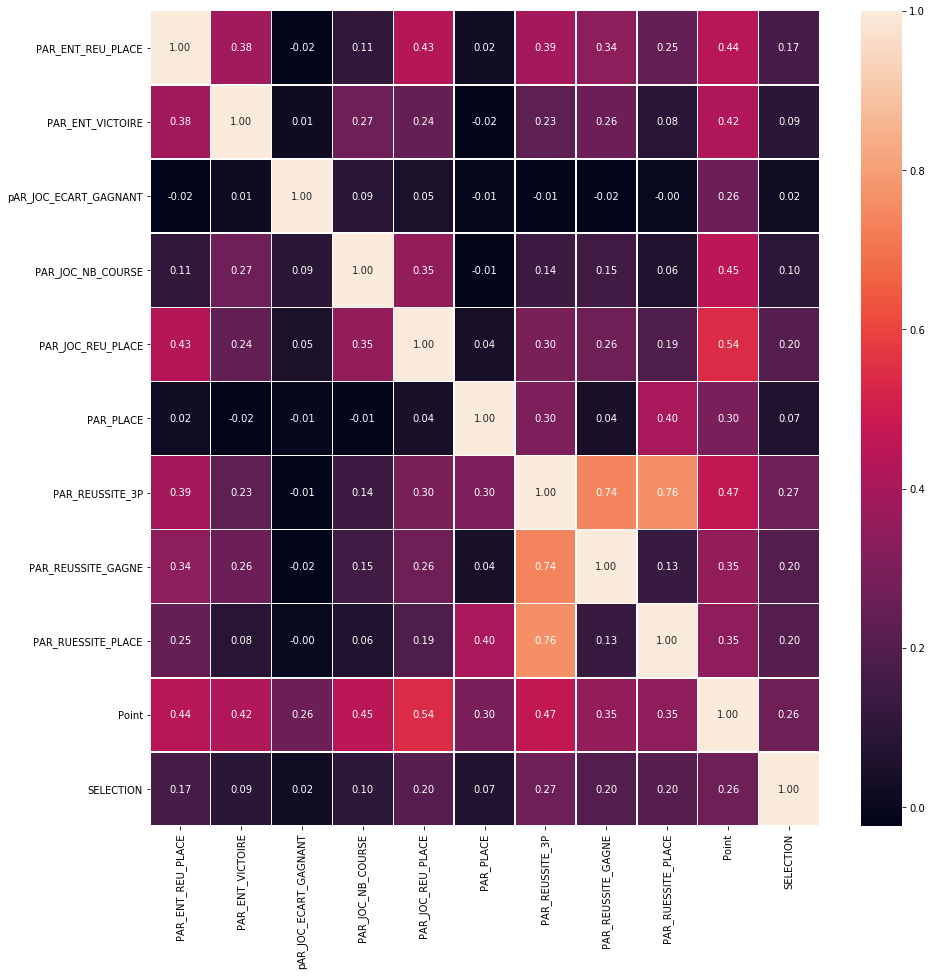

In [30]:
#Enfin, quelque chose de vraiment cool que vous pouvez mettre 

#dans une carte de chaleur est une matrice de corrélation. 
#Pandas DataFrame a une méthode corr qui calcule le coefficient de corrélation de Pearson (peut être un autre)
#entre tous les couples de colonnes numériques du DataFrame.

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_gagnant.corr(), annot=True, fmt=".2f", linewidths=.4, ax=ax)


Proportion: 2.42 : 1
Total number of records : 276545 
Nombre de participations avec SELECTION = 0 : 195698
Nombre de participations avec SELECTION = 1  : 80847
Pourcentage 0: 70.7653%,  pourcentage 1 : 29.2347%


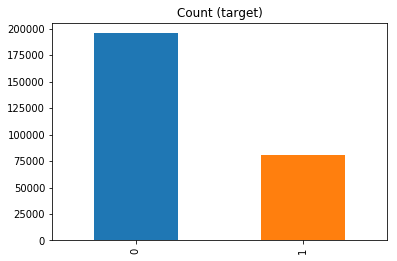

In [31]:
target_count = df_gagnant['SELECTION'].value_counts()


print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)')

normal_trans_perc = sum(df_gagnant['SELECTION'] == 0) / (sum(df_gagnant['SELECTION'] == 0) + sum(df_gagnant['SELECTION'] == 1))
fraud_trans_perc = 1 - normal_trans_perc
print('Total number of records : {} '.format(len(df_gagnant)))
print('Nombre de participations avec SELECTION = 0 : {}'.format(sum(df_gagnant['SELECTION'] == 0)))
print('Nombre de participations avec SELECTION = 1  : {}'.format(sum(df_gagnant['SELECTION'] == 1)))
print('Pourcentage 0: {:.4f}%,  pourcentage 1 : {:.4f}%'.format(normal_trans_perc * 100,fraud_trans_perc * 100))




# Definition des set

In [32]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df_gagnant[feature_columns],
                                                     df_gagnant[response_column], test_size=0.33, random_state=42)
train_eval_X =  df_gagnant[feature_columns]
train_eval_Y=  df_gagnant[response_column]





print("Train_x",train_x.shape)
print("Train y",train_y.shape)
print("Test x",test_x.shape)
print("Test y",test_y.shape)

print("train_eval_X",train_eval_X.shape)
print("train_eval_Y",train_eval_Y.shape)

print("Test x",test_x.shape)
print("Test y",test_y.shape)

test_y = test_y['SELECTION'].ravel()
train_y = train_y['SELECTION'].ravel()



Train_x (185285, 10)
Train y (185285, 1)
Test x (91260, 10)
Test y (91260, 1)
train_eval_X (276545, 10)
train_eval_Y (276545, 1)
Test x (91260, 10)
Test y (91260, 1)


# ESTIMATEUR

In [49]:
 #searchcv,y_pred,predictions=recherche_fit_BayesSearchCV()
model=XGBClassifier(base_score=0.5,
                  booster='gbtree',
                colsample_bylevel=0.2,
                colsample_bytree=0.8,
                 gamma=0.01,
                 learning_rate=0.06, #ok
                max_delta_step=3, #ok
                max_depth=8, #ok
               max_features='sqrt',
                min_child_weight=8, #ok
                n_estimators=1800,#ok
                n_jobs=3,#ok
                nthread=None,
                objective='binary:logistic',
                 random_state=42,
                reg_alpha=0.1, #ok
                reg_lambda=2.5,

                 seed=800,
                subsample=0.99,
                silent=False)

               
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=8, max_features='sqrt',
       min_child_weight=0.5, missing=None, n_estimators=1800, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=800,
       silent=False, subsample=0.9)
 
param_grid = {'silent': [False],
     #   'max_depth': [ 7, 8,9],
     #   'learning_rate': [0.009,0.01,0.011,0.012,0.18,0.02,0.03,0.04, 0.05],
     #   'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
     #   'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
     #   'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
     #   'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
     #   'gamma': [0, 0.25, 0.5, 1.0],
        'seed': [500, 600, 700, 800,900,1000],
     #   'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
        'n_estimators': [500,700,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2000]
              }       

searchcv,y_pred,predictions=recherche_random_XGBClassifier( model, train_x, train_y,test_x,test_y,param_grid,50)

print(searchcv)

model=searchcv

    

Randomized search..
Fitting 10 folds for each of 50 candidates, totalling 500 fits


c:\python\lib\site-packages\sklearn\model_selection\_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 14.6min


[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 63.4min


[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 144.1min


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 251.3min finished


[0]	validation_0-auc:0.690052


Will train until validation_0-auc hasn't improved in 10 rounds.


[1]	validation_0-auc:0.694991


[2]	validation_0-auc:0.696049


[3]	validation_0-auc:0.697239


[4]	validation_0-auc:0.697653


[5]	validation_0-auc:0.697896


[6]	validation_0-auc:0.697904


[7]	validation_0-auc:0.698064


[8]	validation_0-auc:0.698199


[9]	validation_0-auc:0.698524


[10]	validation_0-auc:0.698659


[11]	validation_0-auc:0.698832


[12]	validation_0-auc:0.698863


[13]	validation_0-auc:0.698895


[14]	validation_0-auc:0.698982


[15]	validation_0-auc:0.698999


[16]	validation_0-auc:0.699081


[17]	validation_0-auc:0.69907


[18]	validation_0-auc:0.699151


[19]	validation_0-auc:0.699171


[20]	validation_0-auc:0.699237


[21]	validation_0-auc:0.699266


[22]	validation_0-auc:0.699258


[23]	validation_0-auc:0.699325


[24]	validation_0-auc:0.699353


[25]	validation_0-auc:0.69939


[26]	validation_0-auc:0.699389


[27]	validation_0-auc:0.699397


[28]	validation_0-auc:0.699506


[29]	validation_0-auc:0.699586


[30]	validation_0-auc:0.699665


[31]	validation_0-auc:0.699678


[32]	validation_0-auc:0.699741


[33]	validation_0-auc:0.699797


[34]	validation_0-auc:0.699818


[35]	validation_0-auc:0.699856


[36]	validation_0-auc:0.699879


[37]	validation_0-auc:0.699915


[38]	validation_0-auc:0.699955


[39]	validation_0-auc:0.700009


[40]	validation_0-auc:0.700062


[41]	validation_0-auc:0.700144


[42]	validation_0-auc:0.700117


[43]	validation_0-auc:0.700152


[44]	validation_0-auc:0.700145


[45]	validation_0-auc:0.700156


[46]	validation_0-auc:0.700192


[47]	validation_0-auc:0.700204


[48]	validation_0-auc:0.700258


[49]	validation_0-auc:0.70026


[50]	validation_0-auc:0.700239


[51]	validation_0-auc:0.700258


[52]	validation_0-auc:0.700333


[53]	validation_0-auc:0.700349


[54]	validation_0-auc:0.700394


[55]	validation_0-auc:0.700412


[56]	validation_0-auc:0.700464


[57]	validation_0-auc:0.700495


[58]	validation_0-auc:0.700533


[59]	validation_0-auc:0.700574


[60]	validation_0-auc:0.700612


[61]	validation_0-auc:0.70066


[62]	validation_0-auc:0.700677


[63]	validation_0-auc:0.700712


[64]	validation_0-auc:0.700728


[65]	validation_0-auc:0.700755


[66]	validation_0-auc:0.700794


[67]	validation_0-auc:0.700829


[68]	validation_0-auc:0.700847


[69]	validation_0-auc:0.700872


[70]	validation_0-auc:0.700894


[71]	validation_0-auc:0.700929


[72]	validation_0-auc:0.700951


[73]	validation_0-auc:0.70098


[74]	validation_0-auc:0.701016


[75]	validation_0-auc:0.70103


[76]	validation_0-auc:0.701058


[77]	validation_0-auc:0.701066


[78]	validation_0-auc:0.701102


[79]	validation_0-auc:0.70113


[80]	validation_0-auc:0.701179


[81]	validation_0-auc:0.701187


[82]	validation_0-auc:0.701195


[83]	validation_0-auc:0.701227


[84]	validation_0-auc:0.701248


[85]	validation_0-auc:0.701262


[86]	validation_0-auc:0.701293


[87]	validation_0-auc:0.701318


[88]	validation_0-auc:0.701336


[89]	validation_0-auc:0.701357


[90]	validation_0-auc:0.701385


[91]	validation_0-auc:0.701397


[92]	validation_0-auc:0.701431


[93]	validation_0-auc:0.701463


[94]	validation_0-auc:0.701512


[95]	validation_0-auc:0.701539


[96]	validation_0-auc:0.70155


[97]	validation_0-auc:0.70159


[98]	validation_0-auc:0.70162


[99]	validation_0-auc:0.701653


[100]	validation_0-auc:0.701687


[101]	validation_0-auc:0.701698


[102]	validation_0-auc:0.701733


[103]	validation_0-auc:0.701748


[104]	validation_0-auc:0.701775


[105]	validation_0-auc:0.701779


[106]	validation_0-auc:0.701803


[107]	validation_0-auc:0.701834


[108]	validation_0-auc:0.701858


[109]	validation_0-auc:0.701876


[110]	validation_0-auc:0.701907


[111]	validation_0-auc:0.701943


[112]	validation_0-auc:0.701983


[113]	validation_0-auc:0.702001


[114]	validation_0-auc:0.702019


[115]	validation_0-auc:0.702049


[116]	validation_0-auc:0.702082


[117]	validation_0-auc:0.702103


[118]	validation_0-auc:0.702132


[119]	validation_0-auc:0.702171


[120]	validation_0-auc:0.702202


[121]	validation_0-auc:0.702213


[122]	validation_0-auc:0.70224


[123]	validation_0-auc:0.70228


[124]	validation_0-auc:0.702295


[125]	validation_0-auc:0.702316


[126]	validation_0-auc:0.702354


[127]	validation_0-auc:0.702361


[128]	validation_0-auc:0.702385


[129]	validation_0-auc:0.702404


[130]	validation_0-auc:0.70243


[131]	validation_0-auc:0.702441


[132]	validation_0-auc:0.702469


[133]	validation_0-auc:0.702502


[134]	validation_0-auc:0.702514


[135]	validation_0-auc:0.702526


[136]	validation_0-auc:0.702541


[137]	validation_0-auc:0.702553


[138]	validation_0-auc:0.70257


[139]	validation_0-auc:0.702592


[140]	validation_0-auc:0.702608


[141]	validation_0-auc:0.702613


[142]	validation_0-auc:0.702629


[143]	validation_0-auc:0.702653


[144]	validation_0-auc:0.702662


[145]	validation_0-auc:0.702685


[146]	validation_0-auc:0.702699


[147]	validation_0-auc:0.702724


[148]	validation_0-auc:0.702736


[149]	validation_0-auc:0.702762


[150]	validation_0-auc:0.702786


[151]	validation_0-auc:0.702796


[152]	validation_0-auc:0.702826


[153]	validation_0-auc:0.702849


[154]	validation_0-auc:0.702853


[155]	validation_0-auc:0.702866


[156]	validation_0-auc:0.70289


[157]	validation_0-auc:0.702906


[158]	validation_0-auc:0.702929


[159]	validation_0-auc:0.702951


[160]	validation_0-auc:0.702982


[161]	validation_0-auc:0.703009


[162]	validation_0-auc:0.703019


[163]	validation_0-auc:0.703054


[164]	validation_0-auc:0.70308


[165]	validation_0-auc:0.703095


[166]	validation_0-auc:0.703122


[167]	validation_0-auc:0.703144


[168]	validation_0-auc:0.703162


[169]	validation_0-auc:0.703192


[170]	validation_0-auc:0.703214


[171]	validation_0-auc:0.703233


[172]	validation_0-auc:0.703253


[173]	validation_0-auc:0.703278


[174]	validation_0-auc:0.703303


[175]	validation_0-auc:0.703313


[176]	validation_0-auc:0.703326


[177]	validation_0-auc:0.703351


[178]	validation_0-auc:0.703373


[179]	validation_0-auc:0.703393


[180]	validation_0-auc:0.703405


[181]	validation_0-auc:0.703418


[182]	validation_0-auc:0.703439


[183]	validation_0-auc:0.703453


[184]	validation_0-auc:0.703479


[185]	validation_0-auc:0.703509


[186]	validation_0-auc:0.703523


[187]	validation_0-auc:0.703541


[188]	validation_0-auc:0.703574


[189]	validation_0-auc:0.703595


[190]	validation_0-auc:0.703623


[191]	validation_0-auc:0.703643


[192]	validation_0-auc:0.70366


[193]	validation_0-auc:0.703675


[194]	validation_0-auc:0.703692


[195]	validation_0-auc:0.703709


[196]	validation_0-auc:0.70373


[197]	validation_0-auc:0.703741


[198]	validation_0-auc:0.703752


[199]	validation_0-auc:0.703774


[200]	validation_0-auc:0.703778


[201]	validation_0-auc:0.703794


[202]	validation_0-auc:0.703818


[203]	validation_0-auc:0.703837


[204]	validation_0-auc:0.703856


[205]	validation_0-auc:0.703867


[206]	validation_0-auc:0.70388


[207]	validation_0-auc:0.703905


[208]	validation_0-auc:0.703933


[209]	validation_0-auc:0.703948


[210]	validation_0-auc:0.703967


[211]	validation_0-auc:0.703977


[212]	validation_0-auc:0.703997


[213]	validation_0-auc:0.70401


[214]	validation_0-auc:0.704021


[215]	validation_0-auc:0.704045


[216]	validation_0-auc:0.704058


[217]	validation_0-auc:0.70407


[218]	validation_0-auc:0.70408


[219]	validation_0-auc:0.704103


[220]	validation_0-auc:0.70412


[221]	validation_0-auc:0.704132


[222]	validation_0-auc:0.704155


[223]	validation_0-auc:0.704167


[224]	validation_0-auc:0.704183


[225]	validation_0-auc:0.704204


[226]	validation_0-auc:0.704216


[227]	validation_0-auc:0.704222


[228]	validation_0-auc:0.704232


[229]	validation_0-auc:0.704241


[230]	validation_0-auc:0.704261


[231]	validation_0-auc:0.704265


[232]	validation_0-auc:0.704279


[233]	validation_0-auc:0.704287


[234]	validation_0-auc:0.704308


[235]	validation_0-auc:0.704329


[236]	validation_0-auc:0.704336


[237]	validation_0-auc:0.704354


[238]	validation_0-auc:0.704362


[239]	validation_0-auc:0.704381


[240]	validation_0-auc:0.704391


[241]	validation_0-auc:0.704416


[242]	validation_0-auc:0.704425


[243]	validation_0-auc:0.704444


[244]	validation_0-auc:0.70445


[245]	validation_0-auc:0.704466


[246]	validation_0-auc:0.704473


[247]	validation_0-auc:0.704491


[248]	validation_0-auc:0.704502


[249]	validation_0-auc:0.704508


[250]	validation_0-auc:0.704517


[251]	validation_0-auc:0.704541


[252]	validation_0-auc:0.704563


[253]	validation_0-auc:0.70457


[254]	validation_0-auc:0.704573


[255]	validation_0-auc:0.704598


[256]	validation_0-auc:0.7046


[257]	validation_0-auc:0.704608


[258]	validation_0-auc:0.704613


[259]	validation_0-auc:0.704626


[260]	validation_0-auc:0.70464


[261]	validation_0-auc:0.704655


[262]	validation_0-auc:0.704665


[263]	validation_0-auc:0.704675


[264]	validation_0-auc:0.704698


[265]	validation_0-auc:0.704702


[266]	validation_0-auc:0.704711


[267]	validation_0-auc:0.704727


[268]	validation_0-auc:0.704736


[269]	validation_0-auc:0.70475


[270]	validation_0-auc:0.704753


[271]	validation_0-auc:0.70476


[272]	validation_0-auc:0.704771


[273]	validation_0-auc:0.704785


[274]	validation_0-auc:0.704799


[275]	validation_0-auc:0.704813


[276]	validation_0-auc:0.704824


[277]	validation_0-auc:0.704844


[278]	validation_0-auc:0.704859


[279]	validation_0-auc:0.704879


[280]	validation_0-auc:0.704884


[281]	validation_0-auc:0.704891


[282]	validation_0-auc:0.704907


[283]	validation_0-auc:0.704922


[284]	validation_0-auc:0.704937


[285]	validation_0-auc:0.704946


[286]	validation_0-auc:0.704957


[287]	validation_0-auc:0.704968


[288]	validation_0-auc:0.704975


[289]	validation_0-auc:0.704988


[290]	validation_0-auc:0.705008


[291]	validation_0-auc:0.70502


[292]	validation_0-auc:0.705037


[293]	validation_0-auc:0.705043


[294]	validation_0-auc:0.705045


[295]	validation_0-auc:0.705064


[296]	validation_0-auc:0.705064


[297]	validation_0-auc:0.705075


[298]	validation_0-auc:0.705092


[299]	validation_0-auc:0.705107


[300]	validation_0-auc:0.705118


[301]	validation_0-auc:0.705127


[302]	validation_0-auc:0.705137


[303]	validation_0-auc:0.705142


[304]	validation_0-auc:0.705156


[305]	validation_0-auc:0.705173


[306]	validation_0-auc:0.705186


[307]	validation_0-auc:0.705203


[308]	validation_0-auc:0.705217


[309]	validation_0-auc:0.705225


[310]	validation_0-auc:0.705238


[311]	validation_0-auc:0.705252


[312]	validation_0-auc:0.705259


[313]	validation_0-auc:0.705274


[314]	validation_0-auc:0.705286


[315]	validation_0-auc:0.70529


[316]	validation_0-auc:0.705313


[317]	validation_0-auc:0.705324


[318]	validation_0-auc:0.705328


[319]	validation_0-auc:0.705335


[320]	validation_0-auc:0.705353


[321]	validation_0-auc:0.705357


[322]	validation_0-auc:0.705379


[323]	validation_0-auc:0.705385


[324]	validation_0-auc:0.705389


[325]	validation_0-auc:0.705398


[326]	validation_0-auc:0.70541


[327]	validation_0-auc:0.70542


[328]	validation_0-auc:0.705433


[329]	validation_0-auc:0.705435


[330]	validation_0-auc:0.705452


[331]	validation_0-auc:0.705457


[332]	validation_0-auc:0.70547


[333]	validation_0-auc:0.705485


[334]	validation_0-auc:0.705498


[335]	validation_0-auc:0.705504


[336]	validation_0-auc:0.705509


[337]	validation_0-auc:0.705516


[338]	validation_0-auc:0.705522


[339]	validation_0-auc:0.705535


[340]	validation_0-auc:0.70554


[341]	validation_0-auc:0.705547


[342]	validation_0-auc:0.705558


[343]	validation_0-auc:0.705569


[344]	validation_0-auc:0.70558


[345]	validation_0-auc:0.705587


[346]	validation_0-auc:0.705599


[347]	validation_0-auc:0.705606


[348]	validation_0-auc:0.705606


[349]	validation_0-auc:0.705613


[350]	validation_0-auc:0.705628


[351]	validation_0-auc:0.705637


[352]	validation_0-auc:0.705653


[353]	validation_0-auc:0.705656


[354]	validation_0-auc:0.705658


[355]	validation_0-auc:0.705668


[356]	validation_0-auc:0.70567


[357]	validation_0-auc:0.705676


[358]	validation_0-auc:0.705681


[359]	validation_0-auc:0.705694


[360]	validation_0-auc:0.705702


[361]	validation_0-auc:0.705708


[362]	validation_0-auc:0.705717


[363]	validation_0-auc:0.705723


[364]	validation_0-auc:0.705743


[365]	validation_0-auc:0.70576


[366]	validation_0-auc:0.705766


[367]	validation_0-auc:0.705782


[368]	validation_0-auc:0.705792


[369]	validation_0-auc:0.705799


[370]	validation_0-auc:0.705804


[371]	validation_0-auc:0.705813


[372]	validation_0-auc:0.70581


[373]	validation_0-auc:0.705819


[374]	validation_0-auc:0.705824


[375]	validation_0-auc:0.705831


[376]	validation_0-auc:0.705834


[377]	validation_0-auc:0.705845


[378]	validation_0-auc:0.705854


[379]	validation_0-auc:0.705866


[380]	validation_0-auc:0.705868


[381]	validation_0-auc:0.705869


[382]	validation_0-auc:0.705877


[383]	validation_0-auc:0.705885


[384]	validation_0-auc:0.705887


[385]	validation_0-auc:0.705888


[386]	validation_0-auc:0.705891


[387]	validation_0-auc:0.705897


[388]	validation_0-auc:0.705902


[389]	validation_0-auc:0.705907


[390]	validation_0-auc:0.705908


[391]	validation_0-auc:0.705913


[392]	validation_0-auc:0.705913


[393]	validation_0-auc:0.705919


[394]	validation_0-auc:0.70593


[395]	validation_0-auc:0.705933


[396]	validation_0-auc:0.705936


[397]	validation_0-auc:0.70594


[398]	validation_0-auc:0.705941


[399]	validation_0-auc:0.705943


[400]	validation_0-auc:0.705945


[401]	validation_0-auc:0.705951


[402]	validation_0-auc:0.705954


[403]	validation_0-auc:0.705958


[404]	validation_0-auc:0.705967


[405]	validation_0-auc:0.705969


[406]	validation_0-auc:0.705973


[407]	validation_0-auc:0.705978


[408]	validation_0-auc:0.705987


[409]	validation_0-auc:0.70599


[410]	validation_0-auc:0.705985


[411]	validation_0-auc:0.705994


[412]	validation_0-auc:0.706002


[413]	validation_0-auc:0.706006


[414]	validation_0-auc:0.706002


[415]	validation_0-auc:0.706006


[416]	validation_0-auc:0.70602


[417]	validation_0-auc:0.706024


[418]	validation_0-auc:0.706027


[419]	validation_0-auc:0.706036


[420]	validation_0-auc:0.706035


[421]	validation_0-auc:0.706038


[422]	validation_0-auc:0.706044


[423]	validation_0-auc:0.706054


[424]	validation_0-auc:0.706063


[425]	validation_0-auc:0.70608


[426]	validation_0-auc:0.706089


[427]	validation_0-auc:0.706094


[428]	validation_0-auc:0.706103


[429]	validation_0-auc:0.70611


[430]	validation_0-auc:0.706114


[431]	validation_0-auc:0.706114


[432]	validation_0-auc:0.706117


[433]	validation_0-auc:0.706119


[434]	validation_0-auc:0.70612


[435]	validation_0-auc:0.70613


[436]	validation_0-auc:0.706134


[437]	validation_0-auc:0.706137


[438]	validation_0-auc:0.706149


[439]	validation_0-auc:0.706146


[440]	validation_0-auc:0.706151


[441]	validation_0-auc:0.706157


[442]	validation_0-auc:0.706163


[443]	validation_0-auc:0.706163


[444]	validation_0-auc:0.706163


[445]	validation_0-auc:0.706168


[446]	validation_0-auc:0.706177


[447]	validation_0-auc:0.706177


[448]	validation_0-auc:0.706182


[449]	validation_0-auc:0.706184


[450]	validation_0-auc:0.706188


[451]	validation_0-auc:0.706197


[452]	validation_0-auc:0.706201


[453]	validation_0-auc:0.706203


[454]	validation_0-auc:0.70621


[455]	validation_0-auc:0.706219


[456]	validation_0-auc:0.706219


[457]	validation_0-auc:0.706226


[458]	validation_0-auc:0.706231


[459]	validation_0-auc:0.706236


[460]	validation_0-auc:0.706239


[461]	validation_0-auc:0.706244


[462]	validation_0-auc:0.70625


[463]	validation_0-auc:0.706259


[464]	validation_0-auc:0.706269


[465]	validation_0-auc:0.70627


[466]	validation_0-auc:0.706271


[467]	validation_0-auc:0.706273


[468]	validation_0-auc:0.706279


[469]	validation_0-auc:0.706286


[470]	validation_0-auc:0.706284


[471]	validation_0-auc:0.706288


[472]	validation_0-auc:0.706291


[473]	validation_0-auc:0.706293


[474]	validation_0-auc:0.706297


[475]	validation_0-auc:0.706302


[476]	validation_0-auc:0.706307


[477]	validation_0-auc:0.70631


[478]	validation_0-auc:0.706315


[479]	validation_0-auc:0.706313


[480]	validation_0-auc:0.706319


[481]	validation_0-auc:0.706319


[482]	validation_0-auc:0.706322


[483]	validation_0-auc:0.706325


[484]	validation_0-auc:0.706329


[485]	validation_0-auc:0.706336


[486]	validation_0-auc:0.706343


[487]	validation_0-auc:0.706348


[488]	validation_0-auc:0.706344


[489]	validation_0-auc:0.706342


[490]	validation_0-auc:0.70634


[491]	validation_0-auc:0.706342


[492]	validation_0-auc:0.706344


[493]	validation_0-auc:0.706353


[494]	validation_0-auc:0.706363


[495]	validation_0-auc:0.706362


[496]	validation_0-auc:0.706366


[497]	validation_0-auc:0.706368


[498]	validation_0-auc:0.706374


[499]	validation_0-auc:0.706386


[500]	validation_0-auc:0.706389


[501]	validation_0-auc:0.706393


[502]	validation_0-auc:0.706395


[503]	validation_0-auc:0.706399


[504]	validation_0-auc:0.7064


[505]	validation_0-auc:0.706401


[506]	validation_0-auc:0.706403


[507]	validation_0-auc:0.706407


[508]	validation_0-auc:0.706412


[509]	validation_0-auc:0.706416


[510]	validation_0-auc:0.706421


[511]	validation_0-auc:0.706432


[512]	validation_0-auc:0.706449


[513]	validation_0-auc:0.706451


[514]	validation_0-auc:0.706457


[515]	validation_0-auc:0.706461


[516]	validation_0-auc:0.706462


[517]	validation_0-auc:0.706462


[518]	validation_0-auc:0.706466


[519]	validation_0-auc:0.706468


[520]	validation_0-auc:0.70647


[521]	validation_0-auc:0.706471


[522]	validation_0-auc:0.70647


[523]	validation_0-auc:0.706477


[524]	validation_0-auc:0.706477


[525]	validation_0-auc:0.706479


[526]	validation_0-auc:0.706479


[527]	validation_0-auc:0.70648


[528]	validation_0-auc:0.706486


[529]	validation_0-auc:0.706486


[530]	validation_0-auc:0.706486


[531]	validation_0-auc:0.706485


[532]	validation_0-auc:0.706486


[533]	validation_0-auc:0.70649


[534]	validation_0-auc:0.70649


[535]	validation_0-auc:0.706493


[536]	validation_0-auc:0.706495


[537]	validation_0-auc:0.706501


[538]	validation_0-auc:0.706499


[539]	validation_0-auc:0.706497


[540]	validation_0-auc:0.706498


[541]	validation_0-auc:0.706503


[542]	validation_0-auc:0.706513


[543]	validation_0-auc:0.706517


[544]	validation_0-auc:0.706515


[545]	validation_0-auc:0.706524


[546]	validation_0-auc:0.706527


[547]	validation_0-auc:0.706531


[548]	validation_0-auc:0.706531


[549]	validation_0-auc:0.706536


[550]	validation_0-auc:0.706537


[551]	validation_0-auc:0.706542


[552]	validation_0-auc:0.706542


[553]	validation_0-auc:0.706545


[554]	validation_0-auc:0.706545


[555]	validation_0-auc:0.706549


[556]	validation_0-auc:0.706547


[557]	validation_0-auc:0.706554


[558]	validation_0-auc:0.706556


[559]	validation_0-auc:0.706556


[560]	validation_0-auc:0.706557


[561]	validation_0-auc:0.706559


[562]	validation_0-auc:0.706563


[563]	validation_0-auc:0.706564


[564]	validation_0-auc:0.706569


[565]	validation_0-auc:0.706571


[566]	validation_0-auc:0.706571


[567]	validation_0-auc:0.706571


[568]	validation_0-auc:0.706569


[569]	validation_0-auc:0.70657


[570]	validation_0-auc:0.706572


[571]	validation_0-auc:0.70658


[572]	validation_0-auc:0.706577


[573]	validation_0-auc:0.706575


[574]	validation_0-auc:0.706574


[575]	validation_0-auc:0.706575


[576]	validation_0-auc:0.706582


[577]	validation_0-auc:0.706586


[578]	validation_0-auc:0.706597


[579]	validation_0-auc:0.706597


[580]	validation_0-auc:0.706597


[581]	validation_0-auc:0.706607


[582]	validation_0-auc:0.706611


[583]	validation_0-auc:0.706616


[584]	validation_0-auc:0.706618


[585]	validation_0-auc:0.706618


[586]	validation_0-auc:0.706621


[587]	validation_0-auc:0.706628


[588]	validation_0-auc:0.706631


[589]	validation_0-auc:0.706635


[590]	validation_0-auc:0.706636


[591]	validation_0-auc:0.706638


[592]	validation_0-auc:0.706641


[593]	validation_0-auc:0.706643


[594]	validation_0-auc:0.706645


[595]	validation_0-auc:0.706646


[596]	validation_0-auc:0.706643


[597]	validation_0-auc:0.706649


[598]	validation_0-auc:0.706649


[599]	validation_0-auc:0.706652


[600]	validation_0-auc:0.706654


[601]	validation_0-auc:0.706653


[602]	validation_0-auc:0.706649


[603]	validation_0-auc:0.706654


[604]	validation_0-auc:0.70666


[605]	validation_0-auc:0.706661


[606]	validation_0-auc:0.706664


[607]	validation_0-auc:0.706666


[608]	validation_0-auc:0.706666


[609]	validation_0-auc:0.706666


[610]	validation_0-auc:0.706663


[611]	validation_0-auc:0.706663


[612]	validation_0-auc:0.706666


[613]	validation_0-auc:0.706671


[614]	validation_0-auc:0.706674


[615]	validation_0-auc:0.706674


[616]	validation_0-auc:0.706675


[617]	validation_0-auc:0.706673


[618]	validation_0-auc:0.706674


[619]	validation_0-auc:0.706682


[620]	validation_0-auc:0.706687


[621]	validation_0-auc:0.706693


[622]	validation_0-auc:0.706698


[623]	validation_0-auc:0.706701


[624]	validation_0-auc:0.706704


[625]	validation_0-auc:0.706704


[626]	validation_0-auc:0.706711


[627]	validation_0-auc:0.706708


[628]	validation_0-auc:0.70671


[629]	validation_0-auc:0.706708


[630]	validation_0-auc:0.706709


[631]	validation_0-auc:0.706713


[632]	validation_0-auc:0.706717


[633]	validation_0-auc:0.706715


[634]	validation_0-auc:0.706712


[635]	validation_0-auc:0.706711


[636]	validation_0-auc:0.706711


[637]	validation_0-auc:0.706708


[638]	validation_0-auc:0.706709


[639]	validation_0-auc:0.706707


[640]	validation_0-auc:0.706707


[641]	validation_0-auc:0.706709


[642]	validation_0-auc:0.706709


Stopping. Best iteration:
[632]	validation_0-auc:0.706717



Randomized search time: 15132.194390296936
Best score: -0.545842250060527
Best params: 
n_estimators: 2000
seed: 900
silent: False


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=8, max_features='sqrt',
       min_child_weight=0.5, missing=None, n_estimators=2000, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=0.9)


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=8, max_features='sqrt',
       min_child_weight=0.5, missing=None, n_estimators=2000, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=0.9)


In [50]:
#res=pd.DataFrame(searchcv.cv_results_)

print(searchcv)

model=searchcv

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=8, max_features='sqrt',
       min_child_weight=0.5, missing=None, n_estimators=2000, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=0.9)


In [52]:


eval_set = [(train_x, train_y), (test_x, test_y)]
model.fit(train_x, train_y, eval_metric=["error", "auc"], eval_set=eval_set, verbose=False, early_stopping_rounds=20)
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y, predictions)
print("************************************************************  Accuracy: %.2f%%" % (accuracy * 100.0))


************************************************************  Accuracy: 73.16%


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
ld.save_mymodel(model, allure_etudier)
#model = ld.load_mymodel(allure_etudier)

Sauvegarde modele ...


             precision    recall  f1-score   support

          0       0.75      0.94      0.83     64748
          1       0.60      0.23      0.33     26512

avg / total       0.70      0.73      0.69     91260




                       importance
feature                          
Point                       0.146
PAR_JOC_NB_COURSE           0.127
PAR_REUSSITE_3P             0.110
PAR_RUESSITE_PLACE          0.103
PAR_ENT_REU_PLACE           0.096
PAR_REUSSITE_GAGNE          0.095
PAR_ENT_VICTOIRE            0.089
PAR_JOC_REU_PLACE           0.083
PAR_PLACE                   0.080
pAR_JOC_ECART_GAGNANT       0.071
----------KBEST-----------------
PAR_ENT_REU_PLACE     410.46793585772593
PAR_ENT_VICTOIRE     55372.03006495803
pAR_JOC_ECART_GAGNANT    

 1689.5122389923677
PAR_JOC_NB_COURSE     887065.7333467295
PAR_JOC_REU_PLACE     689.0024335252153
PAR_PLACE     3955.76815932817


PAR_REUSSITE_3P     1103.8031853004568
PAR_REUSSITE_GAGNE     688.5602249326653
PAR_RUESSITE_PLACE     475.2687922538851
Point     242694.24344309105
--------------------------


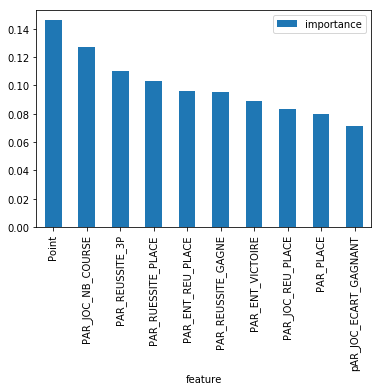

In [54]:
evaluation_1(test_y, predictions,feature_columns, model)

#evaluation_2(model, train_x, train_y, test_x, test_y)    



In [56]:
y_pred = model.predict(test_x)
metrique_classe(y_pred=y_pred, y_true=test_y, xclass=1)


Sensibilité  du reequilibrage des données sur le TEST
La spécificité est intuitivement la capacité du classificateur à trouver tous les échantillons positifs
0.9376196948168283

Calculer la moyenne géométrique
0.46282936092255733


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



EVAL SET ....


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Evaluation TEST-----------------------------------------------------------------------


TEST roc_auc_score :  0.5830411388990598


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[124491   6459]
 [ 40200  14135]]


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[60709  4039]
 [20455  6057]]


Classification Correcte des données de test : 66766/91260    73.160%

Score  TEST  :   73.160  ************************


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


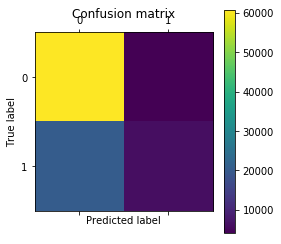

In [57]:
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=1)
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=2)


EVAL SET ....


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


TRAINING roc_auc_score :  0.6054106123913514


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[124491   6459]
 [ 40200  14135]]


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[60709  4039]
 [20455  6057]]



 CLASSIFICATION CORRECTE DES DONNEES DE Train  : 138626/185285    74.818%
Score  TRAINING  :   74.818  ************************


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


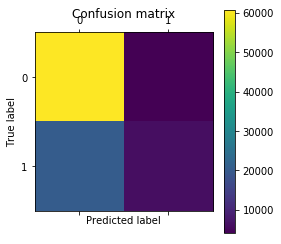

In [59]:
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=2)

# CSV

In [60]:
construireFichierCSV(1, model, feature_columns, response_column, 0)

Lecture data d:\data_jour.csv


Fin de lecture  de d:\data_jour.csv
          0         1  0
0  0.692472  0.307528  0
1  0.688023  0.311977  0
2  0.958765  0.041235  0
3  0.379729  0.620271  1
4  0.505182  0.494818  0


Test_x                        Point   v0   v1  sel
IDPARTCIPANT IDCOURSE                      
1124956      90884       102  0.0  0.0    0
1125037      90891       198  0.0  0.0    0
1125377      90924        45  0.0  0.0    0
1125396      90925       264  0.0  0.0    0


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:




 ALLER DANS APPLICATION DIABOLO ...Allure 1
